## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


Since Tensorflow and keras libraries take a while to compile, I am importing the rest of the packages I need on the go in the next cell, so in this way I don't have to compile again keras and wait for it

In [36]:
from skimage import io
from random import sample 
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import binarize
from keras.models import model_from_json
from keras.preprocessing.image import img_to_array
import sklearn.metrics

## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

print(f'Scans found: {len(all_image_paths)}, Total Headers: {all_xray_df.shape[0]}')
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df

Scans found: 112120, Total Headers: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030804_000.png


In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

def separate_categorical(df, column_name = 'Finding Labels', sep = '|'):
    unique_labels = df[column_name].unique().tolist()
    labels = [unique_labels[i].split(sep) for i in range(len(unique_labels))]
    all_labels = list(np.unique(list(chain(*labels))))
    
    for c_label in all_labels:
         if len(c_label)>1:
            df[c_label] = df[column_name].map(lambda finding: 1.0 if c_label in finding else 0)
    return df, all_labels

In [114]:
all_xray_num , all_labels = separate_categorical(all_xray_df)

In [7]:
all_xray_num

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
all_xray_num_2 = all_xray_num.copy()
all_xray_num_2['Pneumonia_String'] = all_xray_num_2['Pneumonia'].replace(1, 'Pneumonia').replace(0, 'Non-pneumonia')

In [9]:
all_xray_num_2 #This is the dataset I will use from now on

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_String
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Non-pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Non-pneumonia
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Non-pneumonia
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Non-pneumonia


## Create your training and testing data:

#### First: Ensure to have equal amount of positive and negative samples of Pneumothorax in training

In [10]:
train_df, valid_df = train_test_split(all_xray_num_2, test_size = 0.2, stratify = all_xray_num_2['Pneumonia']) 

In [11]:
def disease_proportion(df, disease = 'Pneumonia'): 
    total_hist = np.histogram(df[disease], bins = 2)[0]
    total_prop_disease = total_hist[1]/(total_hist[0] + total_hist[1])
    return total_prop_disease

In [12]:
disease_proportion(train_df)

0.012765340706386016

In [13]:
disease_proportion(valid_df)

0.012754191937210132

In [14]:
train_df.Pneumonia.sum() #There are 1145 pneumonia cases

1145.0

In [15]:
len(train_df)

89696

In [16]:
train_df.Pneumonia.sum()/len(train_df)

0.012765340706386016

In [17]:
valid_df.Pneumonia.sum() #There are 286 pneumonia cases

286.0

In [18]:
len(valid_df)

22424

In [19]:
valid_df.Pneumonia.sum()/len(valid_df)

0.012754191937210132

Great, our train_test_split made sure that we had the same proportions of Pneumothorax in both sets. Now, let's try to have equal amount of positive and negative samples of Pneumothorax in training

In [20]:
true_positives = train_df[train_df.Pneumonia == 1].index.tolist()
negatives = train_df[train_df.Pneumonia == 0].index.tolist() 

true_negatives = sample(negatives, len(true_positives))
train_df_reshaped = train_df.loc[true_positives + true_negatives]

In [21]:
train_df_reshaped.Pneumonia.sum()

1145.0

In [22]:
len(train_df_reshaped)

2290

In [23]:
train_df_reshaped.Pneumonia.sum()/len(train_df_reshaped)

0.5

In [24]:
train_df_reshaped

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_String
90691,00022572_073.png,Infiltration|Pneumonia,73,22572,51,M,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
17285,00004641_000.png,Effusion|Pleural_Thickening|Pneumonia,0,4641,43,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Pneumonia
7881,00002061_000.png,Nodule|Pleural_Thickening|Pneumonia,0,2061,57,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,Pneumonia
89412,00022192_038.png,Pneumonia,38,22192,73,M,PA,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
108694,00029481_004.png,Pneumonia,4,29481,51,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43672,00011246_000.png,No Finding,0,11246,40,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Non-pneumonia
35385,00009339_000.png,Nodule,0,9339,61,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Non-pneumonia
8752,00002305_000.png,No Finding,0,2305,44,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Non-pneumonia
86206,00021255_007.png,Effusion|Infiltration,7,21255,28,M,AP,3044,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-pneumonia


Yeah. Now we have 50% positive samples and 50% negatives

#### Second: ensure to have 20% positive cases of Pneumonia in the Test Set

In [25]:
len(valid_df[valid_df.Pneumonia == 1])

286

In [26]:
len(valid_df)

22424

In [27]:
len(valid_df[valid_df.Pneumonia == 1])/len(valid_df)

0.012754191937210132

In [28]:
disease_proportion(valid_df)

0.012754191937210132

In [29]:
positives_valid = valid_df[valid_df.Pneumonia == 1].index.tolist()
negatives = valid_df[valid_df.Pneumonia == 0].index.tolist() 

# The following code pulls a random sample of non-pneumonia data 
#that's 4 times as big as the pneumonia sample (80 is 4 times 20)
negatives_valid = sample(negatives, 4*len(positives_valid))

valid_df_reshaped = valid_df.loc[positives_valid + negatives_valid]

In [30]:
len(valid_df_reshaped[valid_df_reshaped.Pneumonia == 1])/len(valid_df_reshaped)

0.2

In [31]:
len(valid_df_reshaped[valid_df_reshaped.Pneumonia == 0])/len(valid_df_reshaped)

0.8

Ok, now my validation set is 80% no-pneumonia, 20% pneumonia

SO MY TRAIN AND TEST SETS ARE: ``train_df_reshaped``and ``valid_df_reshaped``

In [32]:
train_set = train_df_reshaped.to_csv('train_set.csv')
test_set = valid_df_reshaped.to_csv('test_set.csv')

# Now we can begin our model-building & training

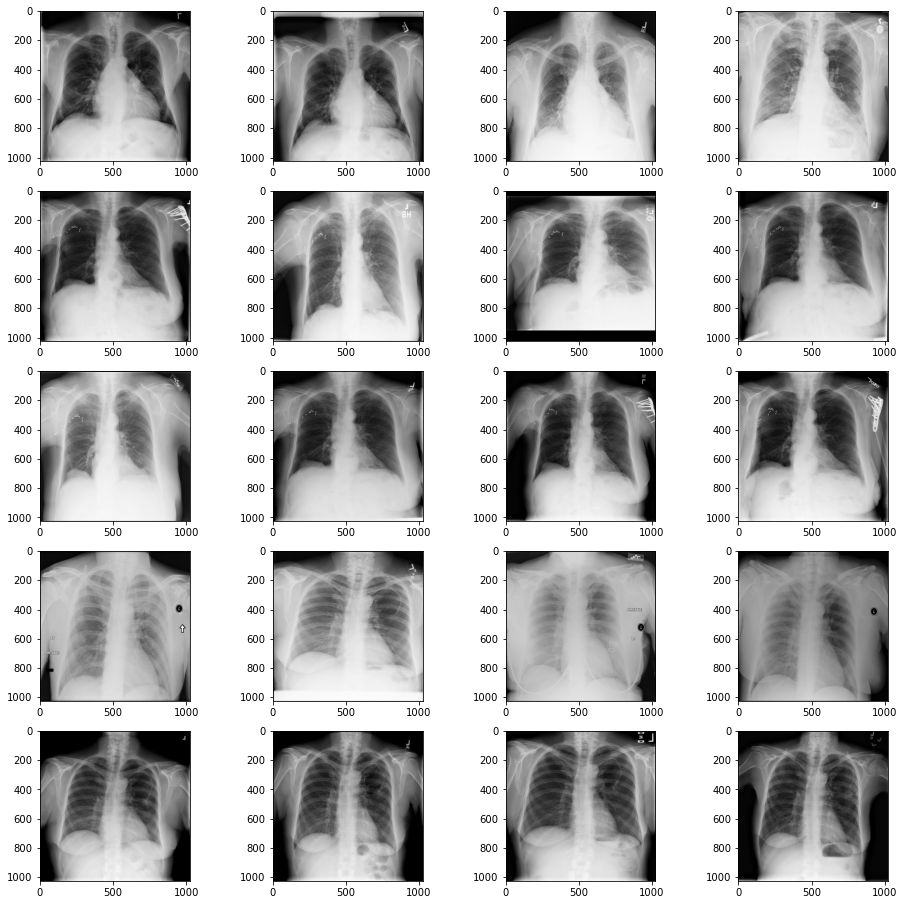

In [31]:
#First, let's look how our images look like: 

fig, axs = plt.subplots(5,4, figsize = (16, 16))
axs = axs.flatten()
imgs = all_xray_num_2.path
ind=0

for img, ax in zip(imgs, axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ind=ind+1

In [41]:
# Image augmentation (ONLY ON THE TRAINING SET)

IMG_SIZE = (224, 224)
batch_size_train = 90
batch_size_test = 32
learning_rate = 1e-4


# Train: 
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 20 , 
                              shear_range = 0.1,
                              zoom_range= 0.1)

train_gen = train_idg.flow_from_dataframe(dataframe = train_df_reshaped, 
                                           directory=None, 
                                           x_col = 'path',
                                           y_col = 'Pneumonia_String',
                                           class_mode = 'binary',
                                           target_size = IMG_SIZE, 
                                           batch_size = batch_size_train)

# Validation (Note that the validation data should not be augmented)
val_idg = ImageDataGenerator(rescale=1. / 255.0)

val_gen = val_idg.flow_from_dataframe(dataframe = valid_df_reshaped, 
                                           directory=None, 
                                           x_col = 'path',
                                           y_col = 'Pneumonia_String',
                                           class_mode = 'binary',
                                           target_size = IMG_SIZE, 
                                           batch_size = batch_size_test)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [42]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

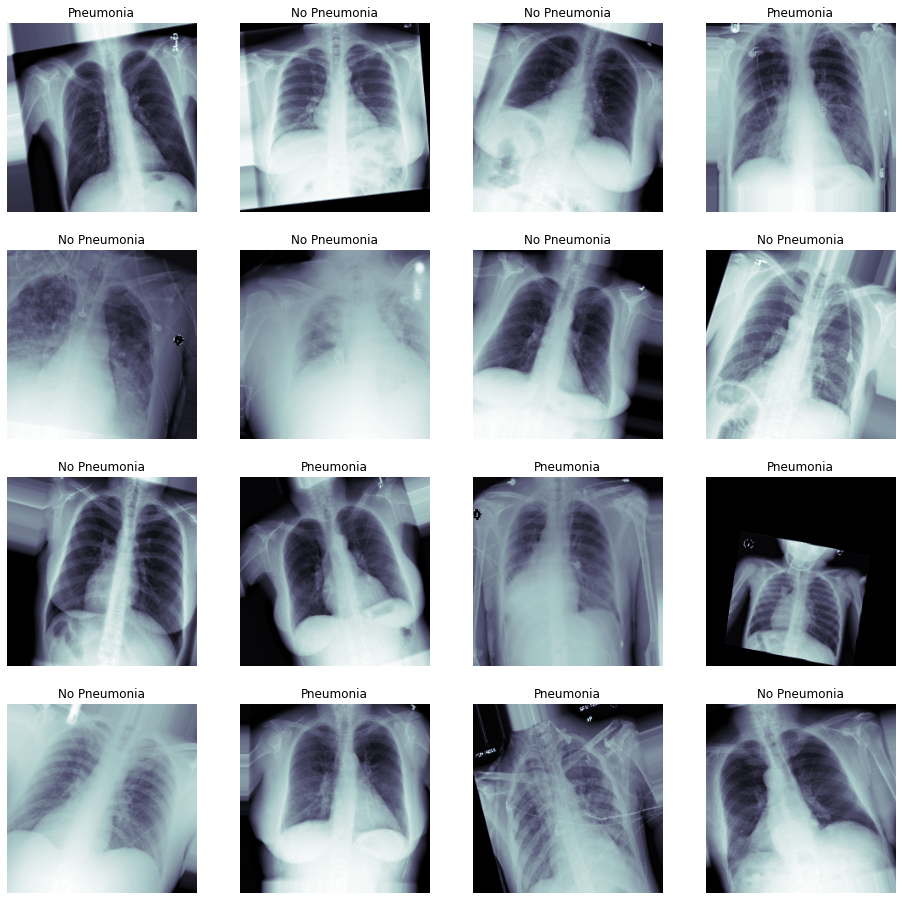

In [36]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

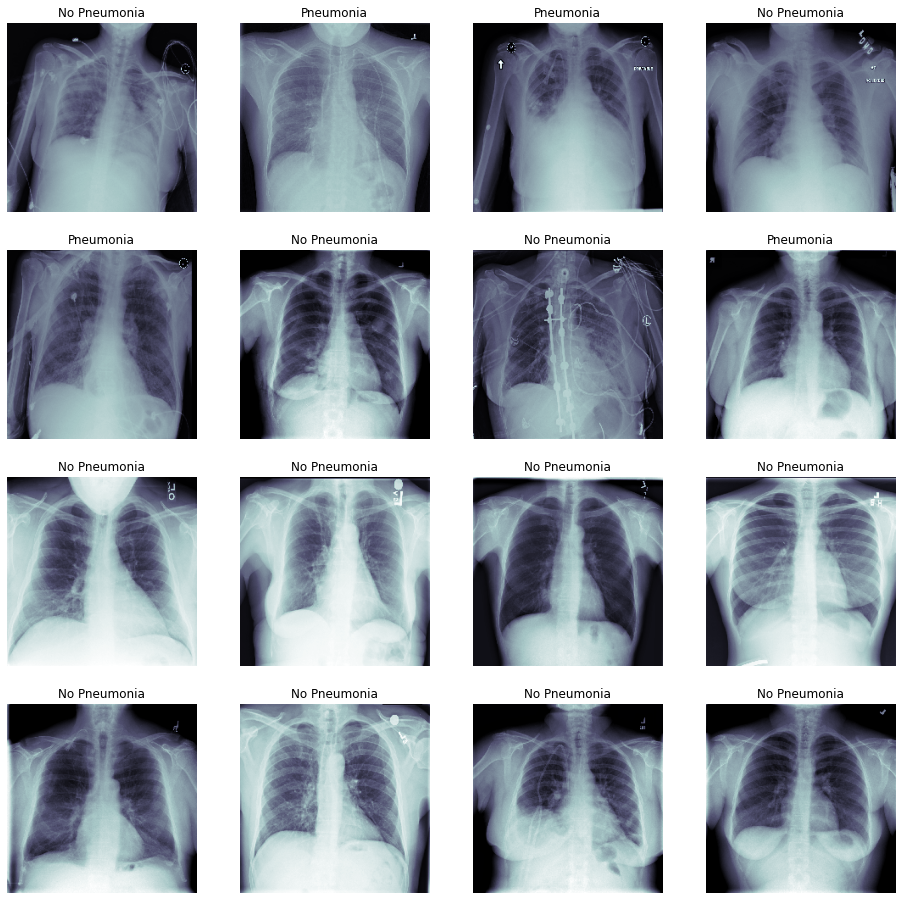

In [37]:
t_x, t_y = next(val_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

We make sure here that the training set has been augmented, but not the validation

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [34]:
def load_pretrained_model(lay_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
    ## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    
    model.summary()
    return vgg_model

In [35]:
vgg_model = load_pretrained_model('block5_pool')

553467904/553467096 [==============================] - 9s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 

In [36]:
def build_my_model(model, optimizer = Adam(lr = learning_rate), 
                   loss = 'binary_crossentropy', metrics = ['binary_accuracy']):
    
    my_model = Sequential()
    #Pre-trained model (convolutional part of the VGG16 model from above)
    my_model.add(model)
    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    my_model.add(Flatten())
    
    # Add a dropout-layer which may prevent overfitting and
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    my_model.add(Dense(256, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    # Set our optimizer, loss function, and learning rate
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [37]:
my_model = build_my_model(vgg_model)
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

### Checkpoints: 

In [38]:
#From Keras documentation
weight_path = '{}_my_model.best.hdf5'.format('xray_class')

#'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only= True)
early = EarlyStopping(monitor= 'val_loss', mode= 'min', patience= 5)
callbacks_list = [checkpoint, early]

### Start training! 

In [39]:
## train your model

# Todo

history_model = my_model.fit_generator(train_gen, 
                                 validation_data = (valX, valY), 
                                 epochs = 10, 
                                 callbacks = callbacks_list)

Epoch 1/10
26/26 [==============================] - 67s 3s/step - loss: 0.8261 - binary_accuracy: 0.5079 - val_loss: 0.6199 - val_binary_accuracy: 0.8438

Epoch 00001: val_loss improved from inf to 0.61992, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
26/26 [==============================] - 57s 2s/step - loss: 0.7391 - binary_accuracy: 0.5306 - val_loss: 0.6532 - val_binary_accuracy: 0.6250

Epoch 00002: val_loss did not improve from 0.61992
Epoch 3/10
26/26 [==============================] - 61s 2s/step - loss: 0.7176 - binary_accuracy: 0.5450 - val_loss: 0.6828 - val_binary_accuracy: 0.5625

Epoch 00003: val_loss did not improve from 0.61992
Epoch 4/10
26/26 [==============================] - 59s 2s/step - loss: 0.6884 - binary_accuracy: 0.5616 - val_loss: 0.6546 - val_binary_accuracy: 0.5625

Epoch 00004: val_loss did not improve from 0.61992
Epoch 5/10
26/26 [==============================] - 61s 2s/step - loss: 0.6844 - binary_accuracy: 0.5690 - val_loss: 0.6910 - val

Although we set 10 epochs, our "patience" parameter is set to 5, so the training stopped when there were at least 5 epochs without val_loss improvement. 

In [40]:
pd.DataFrame(history_model.history).to_csv('history.csv')

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [33]:
#def load_model(model_path, weight_path):
    # todo
    # load json file
#    file = open(model_path)
    # read the json file
#    json_to_model = file.read()
#    model = model_from_json(json_to_model)
    # load weights
#    model.load_weights(weight_path)
    
#    return model

In [34]:
#model_path = 'pneumonia_model_json.json'
#weight_path = 'xray_class_my_model.best.hdf5'

In [37]:
#my_model = load_model(model_path, weight_path)

In [54]:
# val_gen is being used here to pull validation data for performance evaluation
val_idg = ImageDataGenerator(rescale=1. / 255.0)

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df_reshaped, 
                                 directory=None, 
                                 x_col = 'path',
                                 y_col = 'Pneumonia_String',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE, 
                                 batch_size = 100) ## We've only been provided with 6 validation images

Found 1430 validated image filenames belonging to 2 classes.


In [55]:
valX, valY = val_gen.next() # These are the labels we are trying to predict

In [85]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 1, verbose = True)

100/100 [==============================] - 58s 579ms/step


In [57]:
prediction = pred_Y.reshape(-1) # This is the result of the prediction
label= valY.reshape(-1) 

NOTE: 

+ ``valY`` is the actual "true labels" of the images that had been passed to the model. Each value in valY is the label in validation set. 

+ ``predY`` correspond to a single batch of the predictions (obtained from valX). 

In [58]:
# Create a dataframe with these variables
performances = pd.DataFrame({'ground_truth': label, 'probability': prediction})
performances.to_csv('performances.csv')
performances

,ground_truth,probability
0,0.0,0.424167
1,0.0,0.426604
2,0.0,0.435387
3,0.0,0.424353
4,1.0,0.502888
...,...,...
95,0.0,0.482997
96,0.0,0.410869
97,0.0,0.408393
98,0.0,0.385519


## Functions: 

In [164]:
# function to plot the roc_curve. You can utilize roc_curve and auc imported above
def plot_roc_curve(ground_truth, probability):
    fpr, tpr , threshold_roc = roc_curve(ground_truth, probability)
    sens = tpr; esp = fpr
    plt.plot(esp, sens); plt.ylabel('Sensitivity'); plt.xlabel('1-Especificity')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    plt.legend()
    return
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(ground_truth, probability):
    precisions, recalls, thresholds = precision_recall_curve(ground_truth, probability)
    plt.plot(recalls, precisions, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(ground_truth, probability)))
    plt.ylabel('Precision'); plt.xlabel('Recall')
    plt.show()
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'Recall'); 
    plt.xlabel('Threshold'); plt.grid()
    plt.legend()
    return(precisions, recalls, thresholds)

def plot_f1s(valY,pred_Y):
        
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    f1_scores = []
    for i in thresholds:
        f1 = f1_score(valY, binarize(pred_Y,i))
        f1_scores.append(f1)
    fig, c_ax = plt.subplots(1,1, figsize = (10, 10))
    c_ax.plot(thresholds, f1_scores, label = 'F1 Score')
    c_ax.legend()
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1 Score')

# function to calculate the F1 score
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

#Also consider plotting the history of your model training:

def plot_history(history):
    
    pd.DataFrame(history.history).plot(figsize = (8, 5))
    plt.grid(True)
    plt.show()
    return

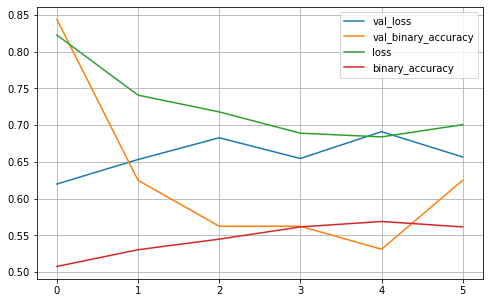

In [53]:
plot_history(history_model)

We can see here that the training accuracy (binary acc) decreases from epoch 4. As well, validation accuracy increases from that point, but I am not sure if it is significant. 

Surely we will need more epochs to determine what is going on here. 

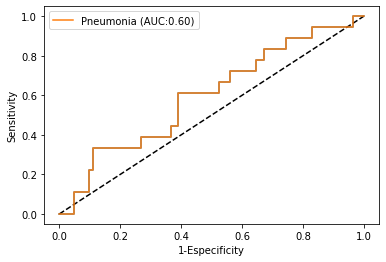

In [54]:
auc_curve = plot_roc_curve(valY, pred_Y)

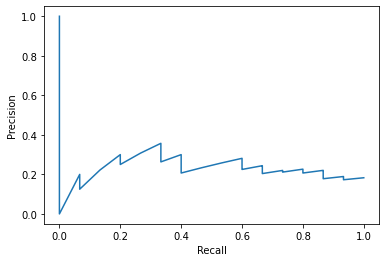

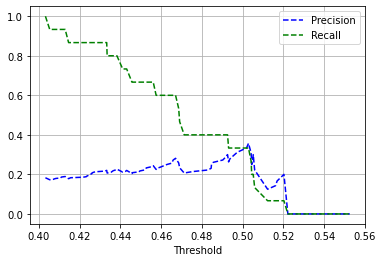

In [165]:
precisions, recalls, thresholds = plot_precision_recall_curve(valY, pred_Y)

We can see here that the maximum threshold is 0.56. This is not such a good point, because that means that the max probability we will have is not better than flipping a coin

In [62]:
pd.DataFrame({'recall': recalls[:-1], 'precision': precisions[:-1], 'thresholds': thresholds})

,recall,precision,thresholds
0,1.000000,0.185567,0.375416
1,0.944444,0.177083,0.378778
2,0.944444,0.178947,0.382729
3,0.944444,0.180851,0.383488
4,0.944444,0.182796,0.388031
...,...,...,...
92,0.055556,0.200000,0.516188
93,0.000000,0.000000,0.516454
94,0.000000,0.000000,0.517288
95,0.000000,0.000000,0.519780


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

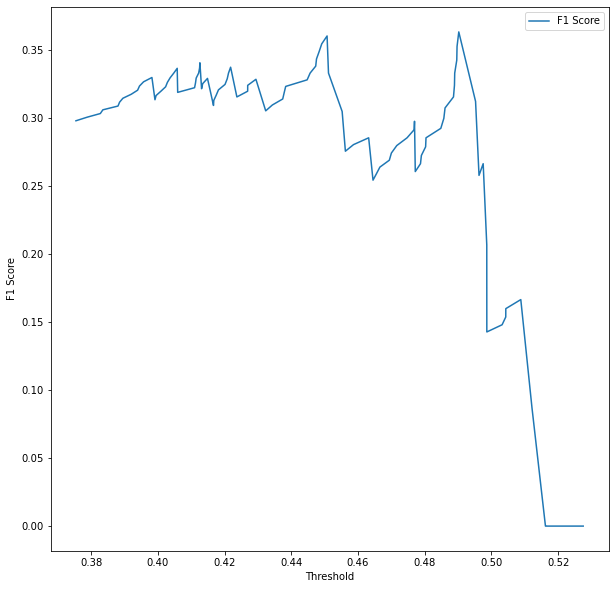

In [65]:
plot_f1s(valY, pred_Y)

Now, let's find the threshold that optimizes model's performance. We will have two scenatios: favouring precision and favouring recall

In [166]:
performances

,ground_truth,probability
0,0.0,0.424167
1,0.0,0.426604
2,0.0,0.435387
3,0.0,0.424353
4,1.0,0.502888
...,...,...
95,0.0,0.482997
96,0.0,0.410869
97,0.0,0.408393
98,0.0,0.385519


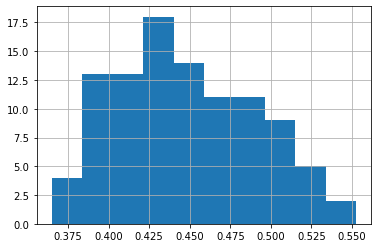

In [189]:
performances.probability.hist()

In [167]:
probs = performances['probability']
# Thresholds 1 and 2
t1 = (probs > 0.79)
t2 = (probs > 0.39)

In [168]:
t1 = t1.replace(True,1).replace(False,0)
t2 = t2.replace(True,1).replace(False,0)

In [169]:
# Look for matches between t1 and ground_truth
compare_t1 = (t1 == performances['ground_truth'])
# Look for matches between t2 and ground_truth
compare_t2 = (t2 == performances['ground_truth'])

In [170]:
print('Accuracy at threshold 1: ' + str(len(compare_t1[compare_t1])/len(performances)))

Accuracy at threshold 1: 0.85


In [171]:
print('Accuracy at threshold 2: ' + str(len(compare_t2[compare_t2])/len(performances)))

Accuracy at threshold 2: 0.23


#### Favouring precision: 

In [172]:
precisions = precisions[:-1]
recalls = recalls[:-1]

In [188]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

#1. Threshold that favours precision
precision_value = 0.90
idx = (np.abs(precisions - precision_value)).argmin() 
print('Precision is: '+ str(precisions[idx]))
print('Recall is: '+ str(recalls[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precisions[idx],recalls[idx])))

Precision is: 0.35714285714285715
Recall is: 0.3333333333333333
Threshold is: 0.502888
F1 Score is: 0.3448275862068965


In [184]:
recall_value = 0.9
idx = (np.abs(recalls - recall_value)).argmin() 
print('Precision is: '+ str(precisions[idx]))
print('Recall is: '+ str(recalls[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precisions[idx],recalls[idx])))

Precision is: 0.1728395061728395
Recall is: 0.9333333333333333
Threshold is: 0.40536928
F1 Score is: 0.29166666666666663


So here we can see that our best threshold, which favours recall, is 0.4

In [191]:
best_threshold = 0.4
YOUR_THRESHOLD = best_threshold

## Algorithm output: 

In [192]:
all_xray_num_2[all_xray_num_2.Pneumonia == 1].Pneumonia.sum()

1431.0

In [193]:
test_idg = ImageDataGenerator(rescale=1. / 255.0)
test_gen = test_idg.flow_from_dataframe(dataframe=valid_df_reshaped, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_String',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 1)

ans = [0]*1430
for i in range(1430):
    testX, testY = test_gen.next()
    if my_model.predict(testX, batch_size = 1430, verbose = True) > YOUR_THRESHOLD:
        ans[i] = 1

Found 1430 validated image filenames belonging to 2 classes.
1/1 [==============================] - 1s 596ms/step


1/1 [==============================] - 1s 577ms/step


1/1 [==============================] - 1s 583ms/step


1/1 [==============================] - 1s 601ms/step


1/1 [==============================] - 1s 578ms/step


1/1 [==============================] - 1s 564ms/step


1/1 [==============================] - 1s 587ms/step


1/1 [==============================] - 1s 579ms/step


1/1 [==============================] - 1s 608ms/step


1/1 [==============================] - 1s 568ms/step


In [194]:
valid_df_reshaped['algorithm_output'] = ans
valid_df_reshaped.algorithm_output.value_counts()

1    1228
0     202
Name: algorithm_output, dtype: int64

In [195]:
pd.DataFrame(valid_df_reshaped).to_csv('model_performances.csv')

## Algorithm's performance in presence of other diseases: 

In [196]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [197]:
labels = all_labels.copy()

labels_1 = labels.remove('No Finding')
labels_2 = labels.remove('Pneumonia')

for i in labels:
    
    tn, fp, fn, tp = confusion_matrix(valid_df_reshaped[valid_df_reshaped[i]==1].Pneumonia.values,
                                                  valid_df_reshaped[valid_df_reshaped[i]==1].algorithm_output.values,labels=[0,1]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(i)
    print('Sensitivity: '+ str(sens))
    print('Specificity: ' +str(spec))
    print('\n')

Atelectasis
Sensitivity: 0.9285714285714286
Specificity: 0.13114754098360656


Cardiomegaly
Sensitivity: 1.0
Specificity: 0.11764705882352941


Consolidation
Sensitivity: 0.9473684210526315
Specificity: 0.1


Edema
Sensitivity: 0.819672131147541
Specificity: 0.05


Effusion
Sensitivity: 0.8970588235294118
Specificity: 0.12878787878787878


Emphysema
Sensitivity: 1.0
Specificity: 0.08695652173913043


Fibrosis
Sensitivity: 0.0
Specificity: 0.03571428571428571


Hernia
Sensitivity: 1.0
Specificity: 0.0


Infiltration
Sensitivity: 0.8679245283018868
Specificity: 0.15151515151515152


Mass
Sensitivity: 0.9166666666666666
Specificity: 0.12962962962962962


Nodule
Sensitivity: 0.8888888888888888
Specificity: 0.125


Pleural_Thickening
Sensitivity: 0.7
Specificity: 0.1388888888888889


Pneumothorax
Sensitivity: 0.8888888888888888
Specificity: 0.15789473684210525




Here we can see that sensitivity (or recall) is favoured at expenses of specificity. However, attending to these results, we infer that the algorithm does not perform well for patients with Fibrosis comorbidity. As well, comorbidity with pleural thickening also worsened the performance. 

## Examples

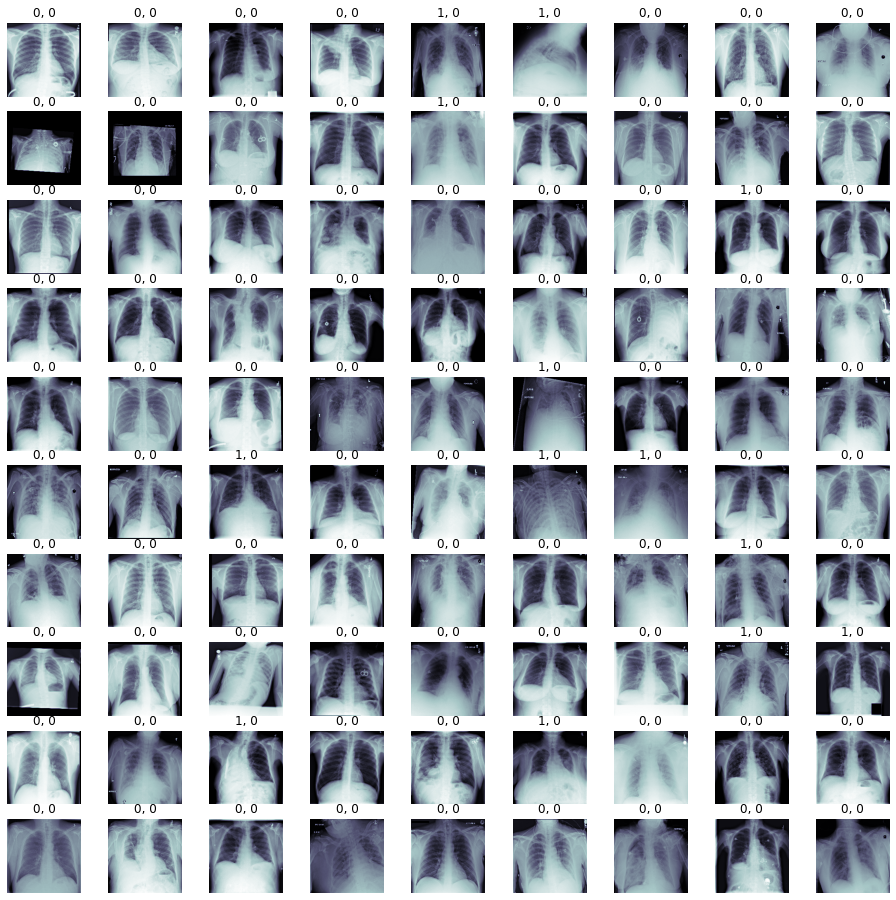

In [143]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 9, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
            if pred_Y[i] > 0.6:
                 c_ax.set_title('1, 1')
            else:
                 c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.6: 
             c_ax.set_title('0, 1')
        else:
             c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

## Saving architecture

In [144]:
## Just save model architecture to a .json:

pneumonia_model_json = my_model.to_json()
with open("pneumonia_model_json.json", "w") as json_file:
    json_file.write(pneumonia_model_json)